<a href="https://colab.research.google.com/github/DolapoSalim/posidonia-identification-model-using-roboflow/blob/main/notebooks/train-yolov8-instance-segmentation-on-custom-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train YOLOv8 Instance Segmentation on a Custom Dataset


Ultralytics YOLOv8 is a popular version of the YOLO (You Only Look Once) object detection and image segmentation model developed by Ultralytics. The YOLOv8 model is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection and image segmentation tasks. It can be trained on large datasets and is capable of running on a variety of hardware platforms, from CPUs to GPUs.

## Confirm GPU setup

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Thu Oct 24 18:39:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

YOLOv8 can be installed in two ways - from the source and via pip. This is because it is the first iteration of YOLO to have an official package.

In [2]:
# Pip install method (recommended)

!pip install ultralytics==8.2.103 -q

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 35.5/112.6 GB disk)


In [3]:
from ultralytics import YOLO

from IPython.display import display, Image

## CLI Basics

If you want to train, validate or run inference on models and don't need to make any modifications to the code, using YOLO command line interface is the easiest way to get started. Read more about CLI in [Ultralytics YOLO Docs](https://docs.ultralytics.com/usage/cli/).

```
yolo task=detect    mode=train    model=yolov8n.yaml      args...
          classify       predict        yolov8n-cls.yaml  args...
          segment        val            yolov8n-seg.yaml  args...
                         export         yolov8n.pt        format=onnx  args...
```

## Inference with Pre-trained COCO Model

### 💻 CLI

In [ ]:
!mkdir -p {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow==1.1.48 --quiet

import roboflow

roboflow.login()

rf = roboflow.Roboflow()

project = rf.workspace("model-examples").project("car-parts-instance-segmentation")
dataset = project.version(3).download("yolov8")

## Custom Training

In [ ]:
%cd {HOME}

!yolo task=segment mode=train model=yolov8s-seg.pt data={dataset.location}/data.yaml epochs=10 imgsz=640

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train/confusion_matrix.png', width=600)

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train/results.png', width=600)

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [ ]:
%cd {HOME}

!yolo task=segment mode=val model={HOME}/runs/segment/train/weights/best.pt data={dataset.location}/data.yaml

/content
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-seg summary (fused): 195 layers, 11,785,018 parameters, 0 gradients, 42.5 GFLOPs
val: Scanning /content/datasets/car-parts-instance-segmentation-3/valid/labels.cache... 1759 images, 0 backgrounds, 0 corrupt: 100% 1759/1759 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/datasets/car-parts-instance-segmentation-3/valid/images/0029502_sc-161833_jpg.rf.18726f063e755947d8ef2e64664679ee.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/car-parts-instance-segmentation-3/valid/images/0177909_as-0042156_jpg.rf.e0dd19ba71adf8d03f3b8ad49a2bc0d1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/car-parts-instance-segmentation-3/valid/images/0237724_as-0068252_jpg.rf.75d25a35ff1df2bf204b16a79e225c2e.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/car-parts-instance-segmentation-3/valid/images/0462933_as-0092659_jpg.rf.7ab699b9e377e535e23990c1de5cb2a3.

## Inference with Custom Model

In [ ]:
%cd {HOME}
!yolo task=segment mode=predict model={HOME}/runs/segment/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=true

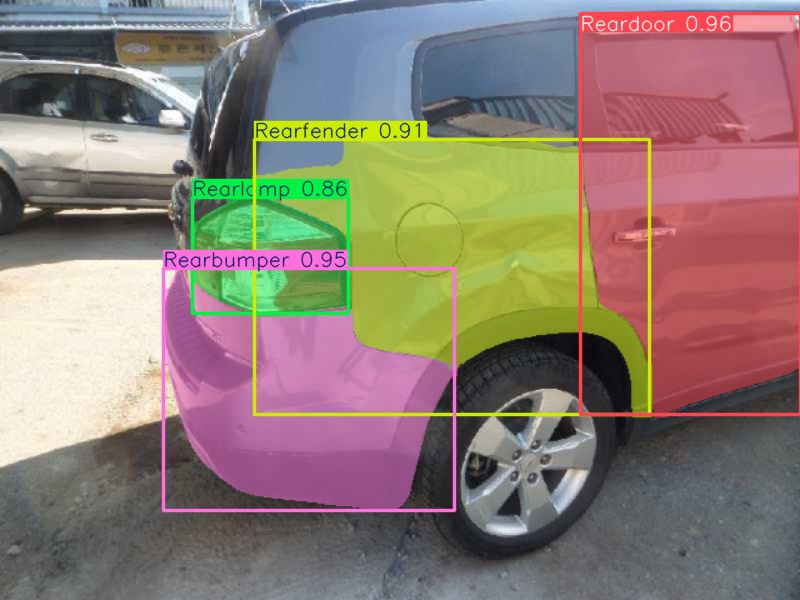

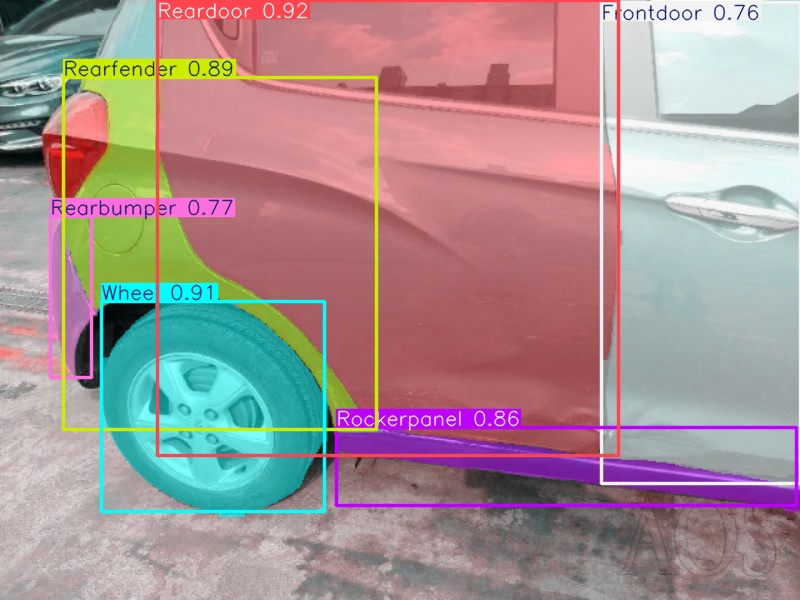

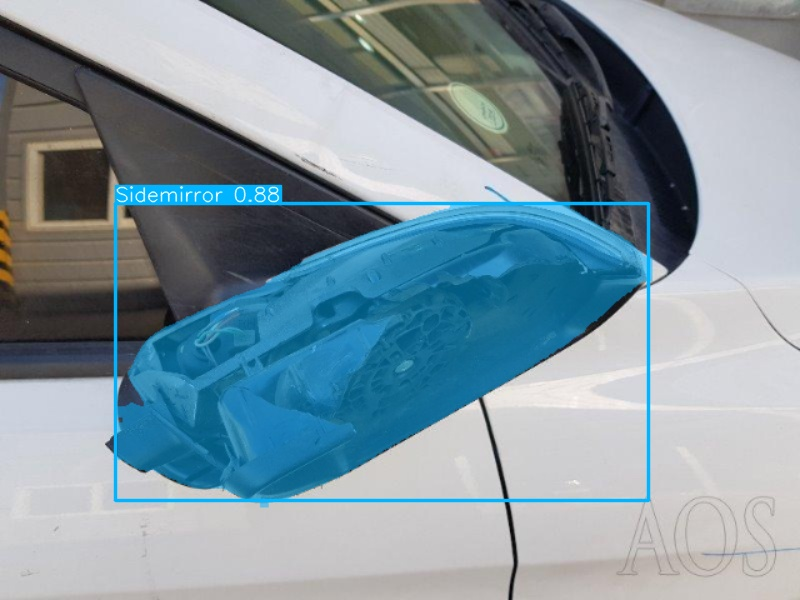

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/segment/predict2/*.jpg')[:3]:
      display(Image(filename=image_path, height=600))
      print("\n")

## Save & Deploy model

Once you have finished training your YOLOv8 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload and your model weights to Roboflow Deploy for autolabeling, autoscaling inference, and storage for later use.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) supports uploading YOLOv8 weights.

Run this cell to save your model weights: